In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_3DLorenz.recursive_LSTM_PostMeanScore_3DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


0.05364725119883322 0.005444221366694382 inf


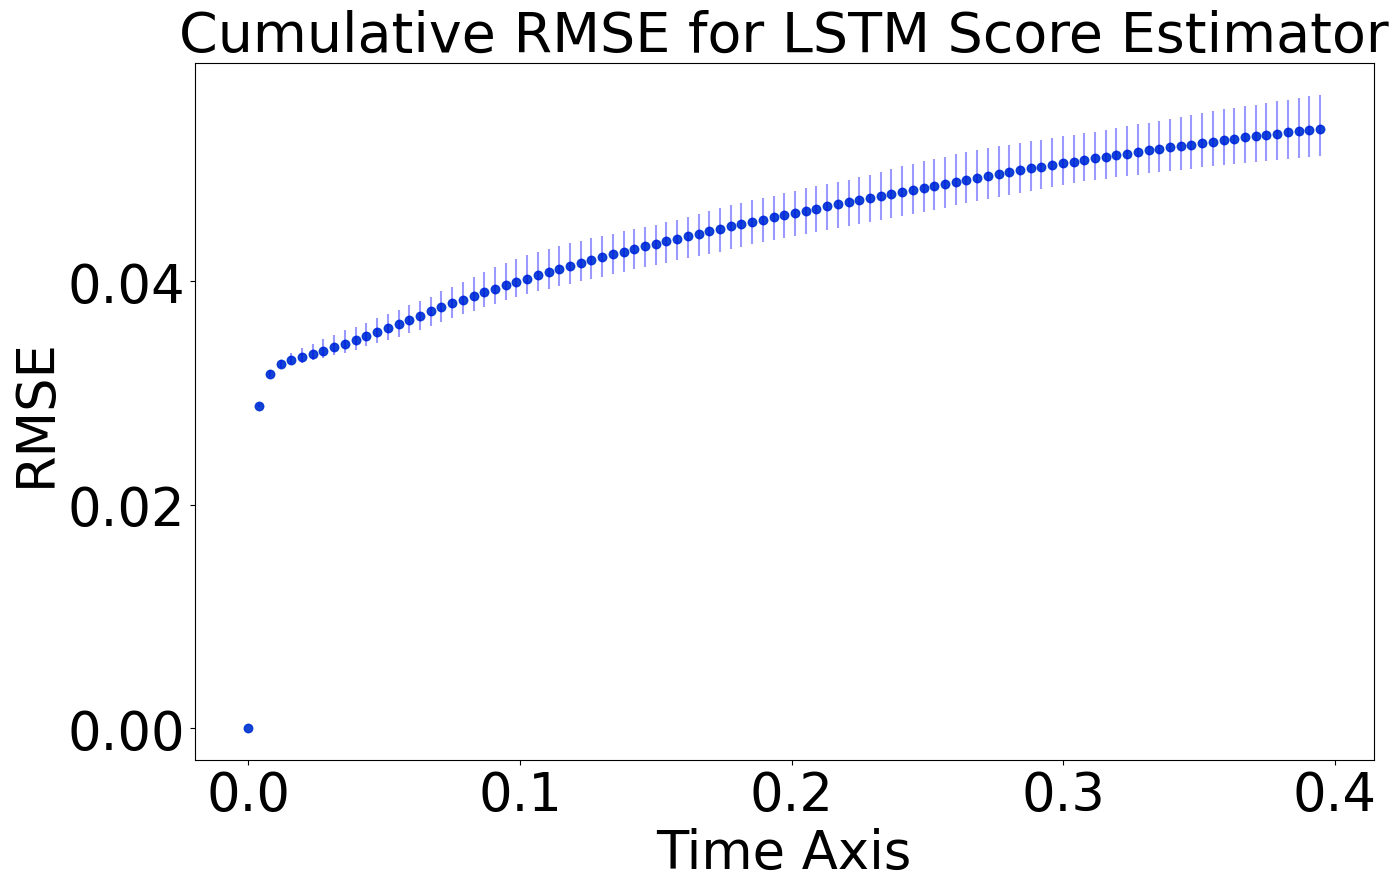

Final time cumulative RMSE local-time error 0.05364725119883322 with final IQR (0.05123142064871921, 0.05667564201541359) at Nepoch 60

0.046787165384585376 0.008292854051574768 0.05364725119883322


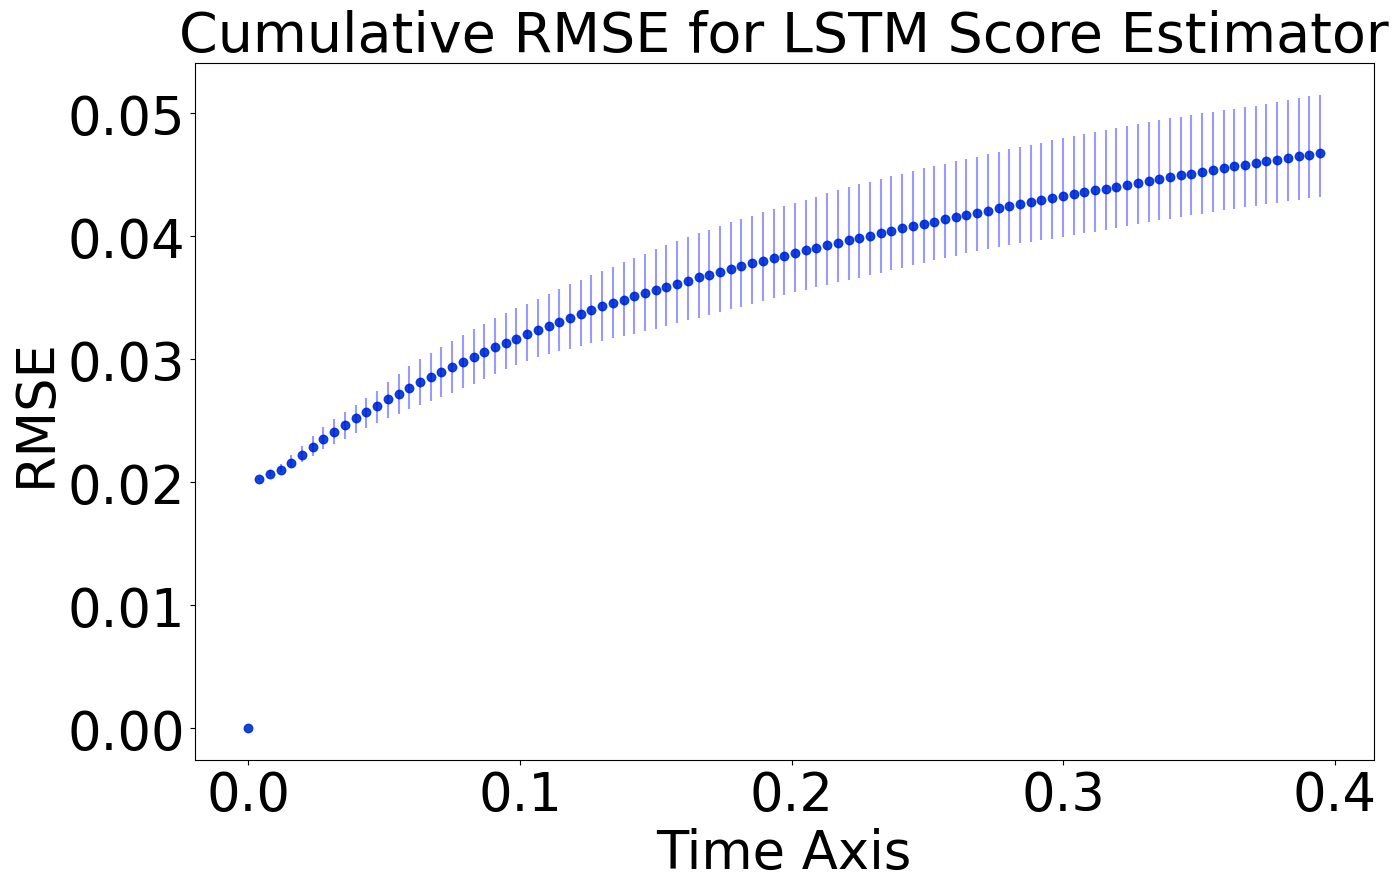

Final time cumulative RMSE local-time error 0.046787165384585376 with final IQR (0.043234740915051716, 0.05152759496662648) at Nepoch 100

0.045757913732966296 0.003999483222890371 0.046787165384585376


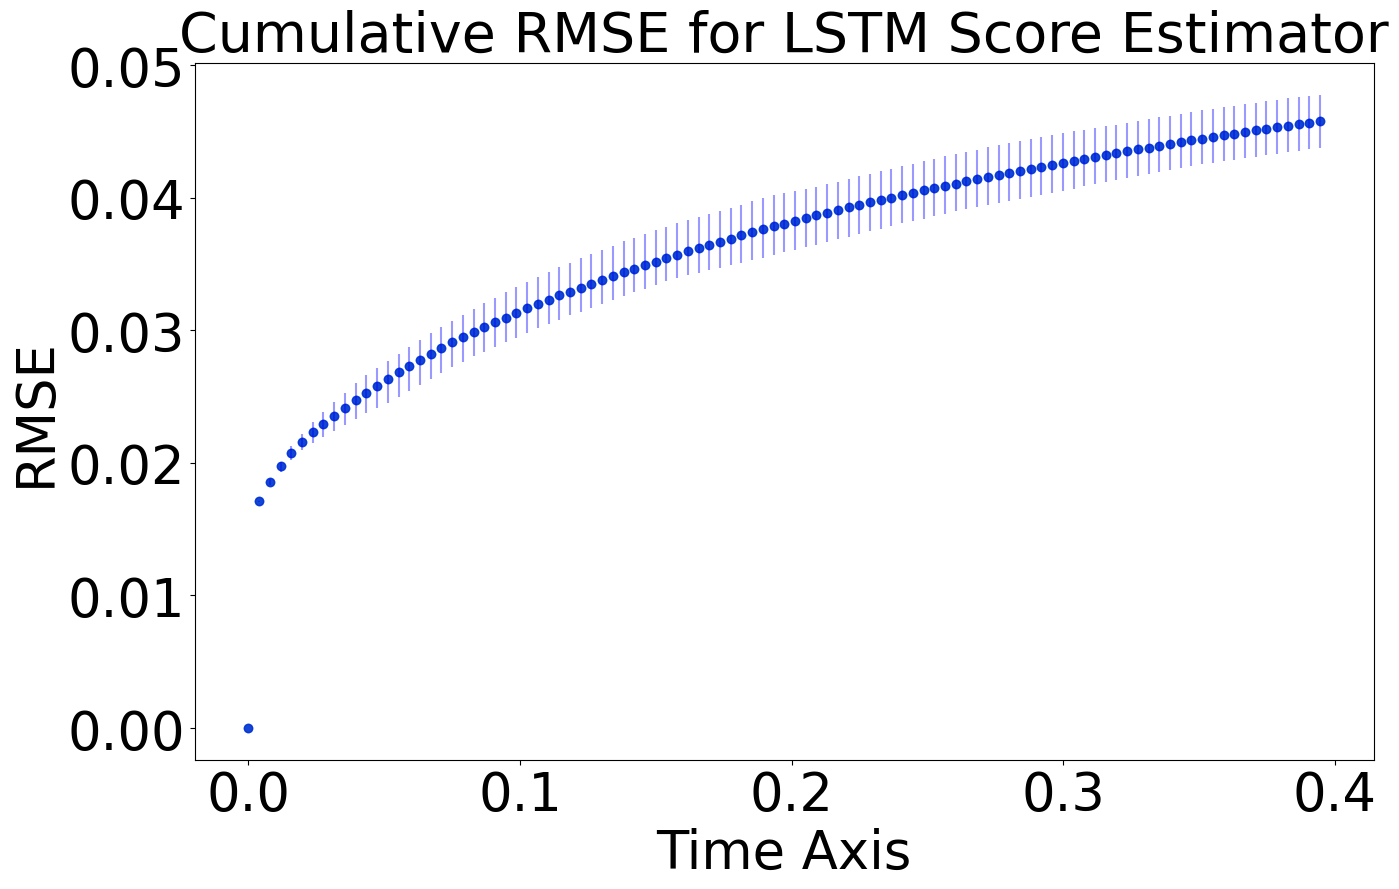

Final time cumulative RMSE local-time error 0.045757913732966296 with final IQR (0.043780163048287024, 0.047779646271177395) at Nepoch 150

0.042256101148883375 0.007249010436006731 0.045757913732966296


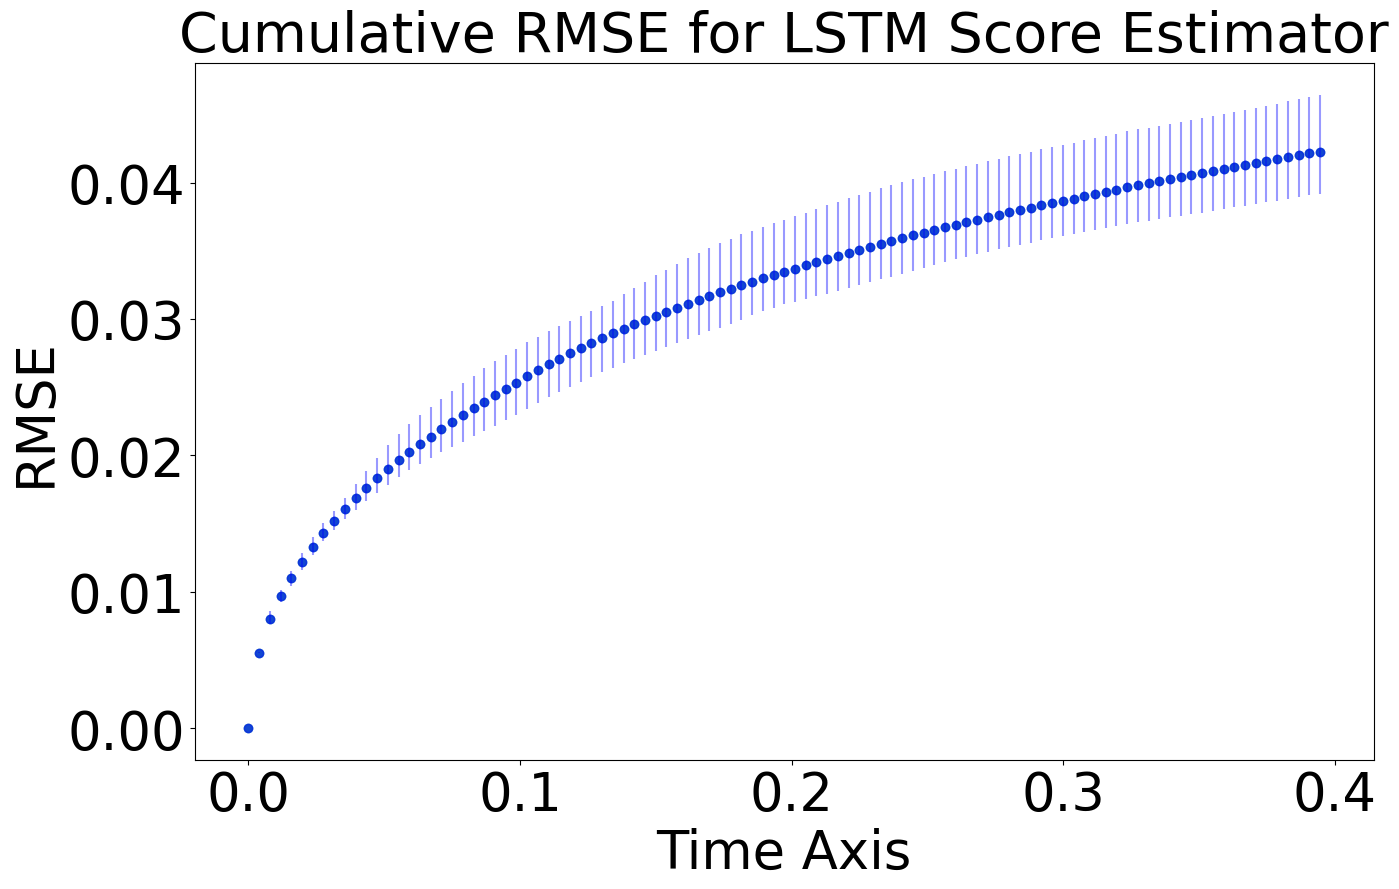

Final time cumulative RMSE local-time error 0.042256101148883375 with final IQR (0.0391907719940795, 0.04643978243008623) at Nepoch 300

0.04282343775681348 0.008003262834723787 0.042256101148883375
0.04251056042754102 0.006412061459176117 0.042256101148883375
0.046818493387033075 0.00887018567899625 0.042256101148883375
0.0478380774414473 0.007102697550676523 0.042256101148883375
0.043283910164732084 0.007645883444244661 0.042256101148883375
0.042122130582188645 0.005227942508468621 0.042256101148883375


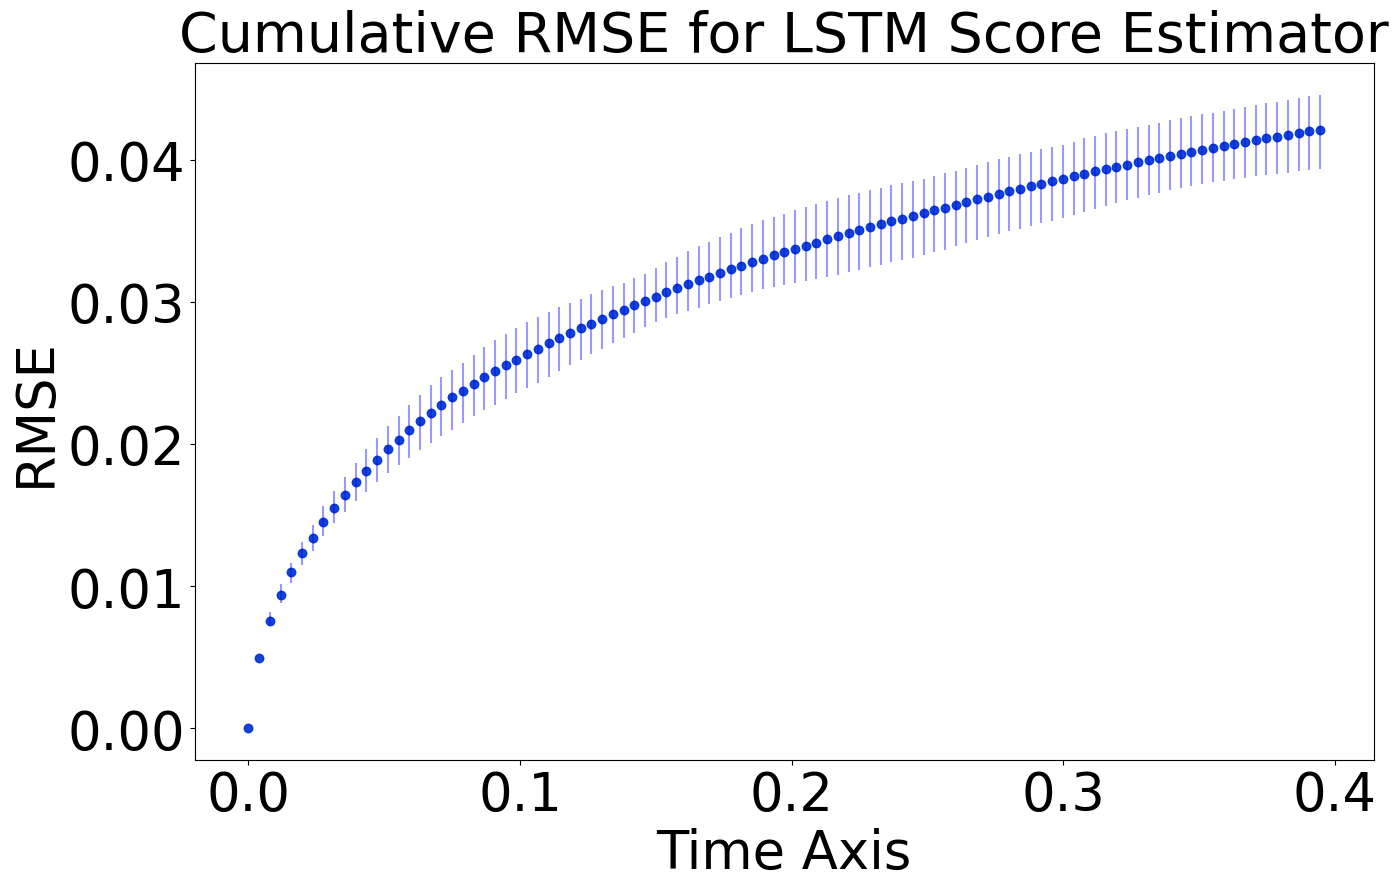

Final time cumulative RMSE local-time error 0.042122130582188645 with final IQR (0.039364684015337555, 0.044592626523806175) at Nepoch 7190

0.04186004004280039 0.006145617970264791 0.042122130582188645


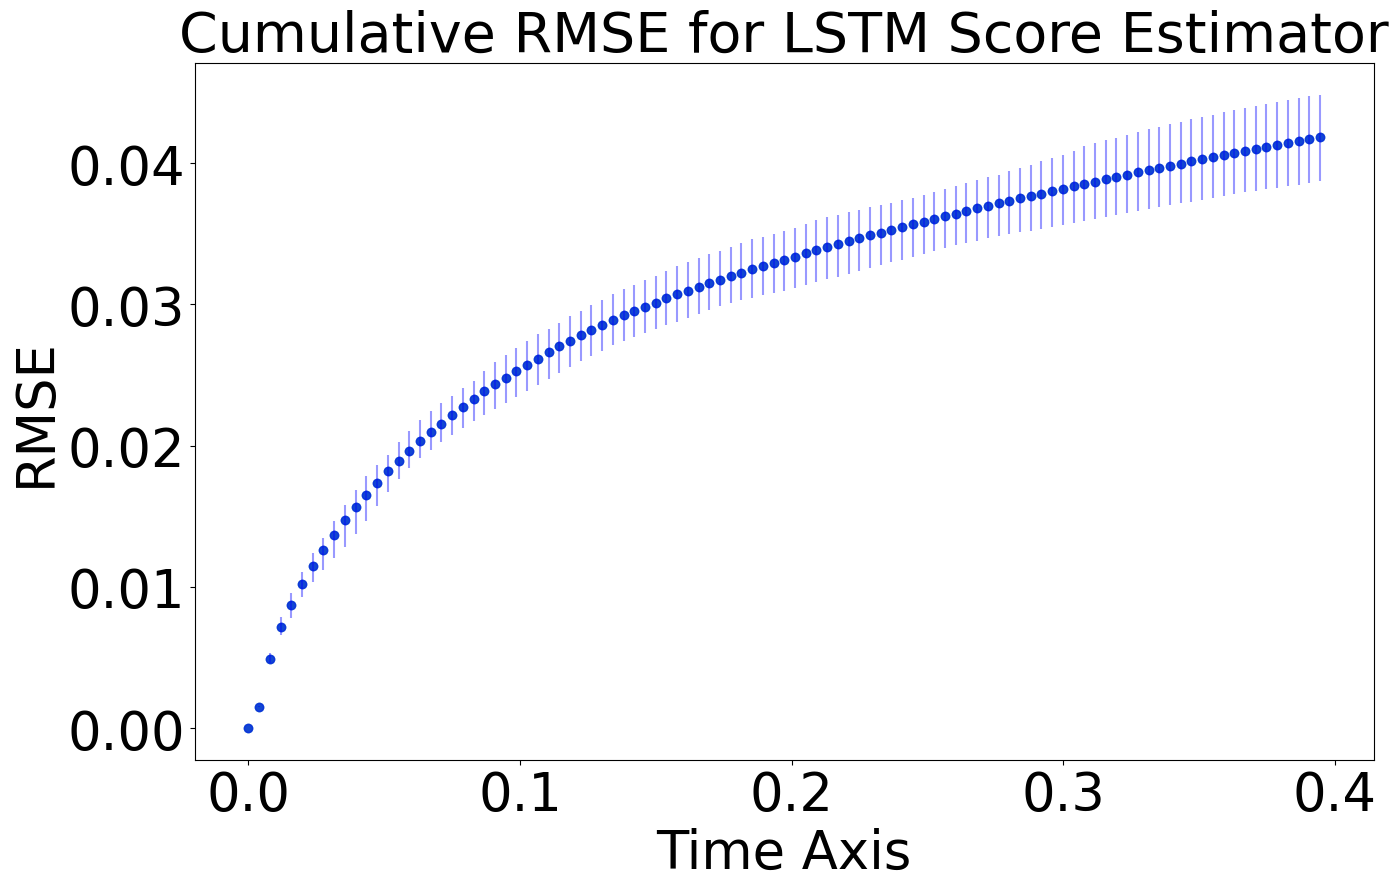

Final time cumulative RMSE local-time error 0.04186004004280039 with final IQR (0.0387001049132909, 0.04484572288355569) at Nepoch 8190



In [6]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{config.ts_beta:.1e}Beta_{config.ts_rho:.1e}Rho_{config.ts_sigma:.1e}Sigma").replace(
            ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f3DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {total_local_errors_minq[-1],total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue